In [1]:
from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
from sklearn.tree import DecisionTreeRegressor

In [3]:
df_train = pd.read_csv('./data/train_10M.csv') 
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [4]:
# MinMaxScaler             : 4.53
# MaxAbsScaler             : 
# StandardScaler           : 5.01
# RobustScaler             : 5.22
# Normalizer               : 
# QuantileTransformer      : 7.00
# PowerTransformer         : 

scaler = 'MinMaxScaler'

In [5]:
df_train = add_features(df_train)
df_train = clean_df(df_train)
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis=1)
df_train, lat_scaler, lon_scaler = scale_gps(df_train, scaler)
df_train = drop_date(df_train)

Old size: 10000000
New size: 9633165


In [6]:
cols = df_train.columns.tolist()
cols.remove('fare_amount')

X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
%%time

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred[y_pred < 0] =2.5

print('RMSE:', math.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2 :', r2_score(y_test, y_pred))

RMSE: 4.462115167387543
R^2 : 0.7777292993772784
CPU times: user 3min 39s, sys: 1.47 s, total: 3min 41s
Wall time: 3min 38s


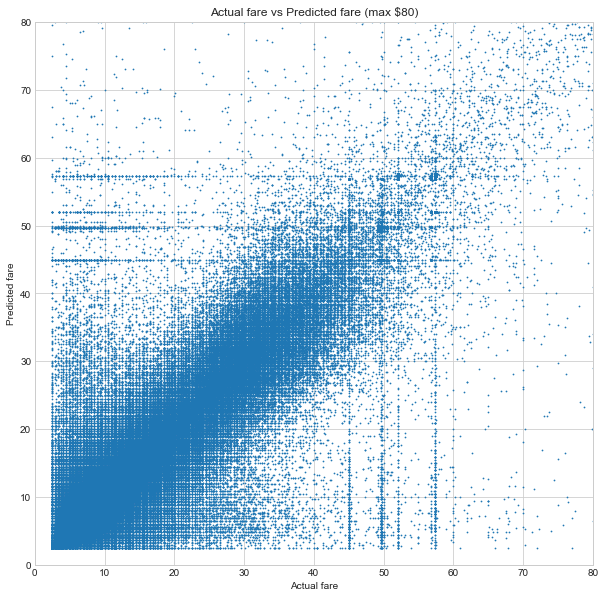

In [8]:
plot_predictions(y_test, y_pred)

---

# Creating the Kaggle submission file (prediction on official test set)

In [9]:
df_test = pd.read_csv('./data/test.csv') 
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

df_test = add_features(df_test)
df_test, lat_scaler, lon_scaler = scale_gps(df_test, scaler, lat_scaler, lon_scaler)
df_test = drop_date(df_test)

df_test = df_test.drop(['key'], axis=1)

In [10]:
pred_test = model.predict(df_test)
pred_test[pred_test < 0] = 2.5

In [11]:
df_test = pd.read_csv('./data/test.csv') 

submission = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test.round(2)
})

submission.to_csv('01_5_taxi_fare_submission.csv',index=False)